<a href="https://colab.research.google.com/github/SangMin316/EEG_Data/blob/main/220918_TTI_Pretext_Task_10s_Sleepedf%2BMASS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


data analysis

In [2]:
import pickle

with open('/content/drive/MyDrive/EEG_data/Sleep/150.pickle','rb') as f:
    sample_data =  pickle.load(f)
print(sample_data.shape)


(2, 8106000)


In [3]:
import pandas as pd
import numpy as np
df = pd.DataFrame(np.transpose(sample_data), columns = ['ch1','ch2'])


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8106000 entries, 0 to 8105999
Data columns (total 2 columns):
 #   Column  Dtype  
---  ------  -----  
 0   ch1     float64
 1   ch2     float64
dtypes: float64(2)
memory usage: 123.7 MB


In [5]:
df['ch1'].sort_values()

6681412   -181.0
1981486   -181.0
1981487   -181.0
1981488   -181.0
1981489   -181.0
           ...  
5968799    179.0
5424095    179.0
1572198    179.0
698369     179.0
698367     179.0
Name: ch1, Length: 8106000, dtype: float64

In [6]:
df['ch2'].sort_values()

6322239   -184.0
6322237   -184.0
6322238   -184.0
6322240   -184.0
6322241   -184.0
           ...  
6681416    182.0
6681420    182.0
6681419    182.0
6681417    182.0
7325001    182.0
Name: ch2, Length: 8106000, dtype: float64


signal values are about -182 ~ 182.

----

Plot the signal

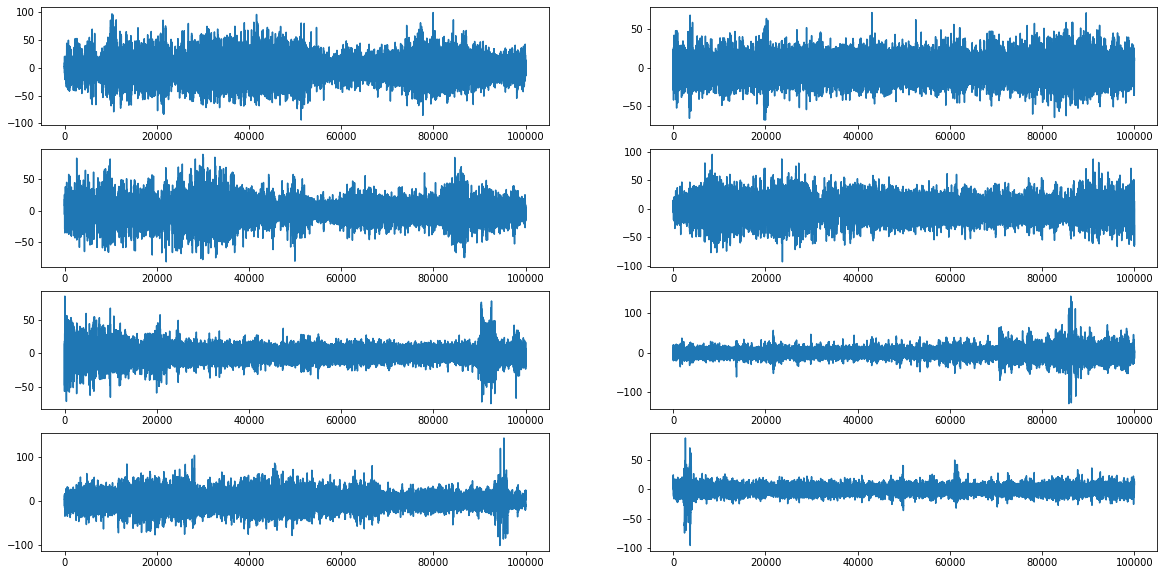

In [7]:
import matplotlib.pyplot as plt
x = np.linspace(0,100000,100000)
plt.figure(figsize =(20, 10))

for i in range(8):
  y = sample_data[1,i*100000:(1+i)*100000]
  x
  plt.subplot(4, 2, i+1)
  plt.plot(x,y)
plt.show()  

data augmentation

In [8]:
import numpy as np
def MAF(x,window):
    new_signals = np.zeros(x.shape)
    sample_num, T = x.shape
    for i in range(sample_num):
      noise = np.convolve(x[i], np.ones(window),'same')/window
      new_signals[i] = x[i] - noise
   
    return new_signals


def asln(x,a,b):

    C,T = x.shape
    noise = a*np.linspace(0,1,T) - b*np.ones(T)
    noise = noise*np.ones((C,1))
    n = np.random.randint(2)
    if n == 0:
      new_signals = x + noise
    else:
      new_signals = x - noise
    return new_signals

def apn(x,c,d):
    C,T = x.shape
    noise = np.linspace(-np.pi+d,np.pi+d,T) - d*np.ones(T)
    noise = c*np.sin(noise)*np.ones((C,1))
    new_signals = x + noise
    return new_signals

In [9]:
def augmented_data(x,window,a,b,c,d):
      samples, sequence_length = x.shape
      X = []
      Y = []
      X.append(x)

      x_maf = MAF(x,window)
      x_asln = asln(x,a,b)
      x_apn = apn(x,c,d)
      
      
      X.append(x_maf)
      X.append(x_asln)
      X.append(x_apn)
      
      del x

      #one-hot encoding
      original = [1,0,0,0]
      s_maf = [0,1,0,0]
      s_asln = [0,0,1,0]
      s_apn = [0,0,0,1]

      Y.append(original*np.ones((samples,1)))
      Y.append(s_maf*np.ones((samples,1)))
      Y.append(s_asln*np.ones((samples,1)))
      Y.append(s_apn*np.ones((samples,1)))
      
      X = np.array(X)
      print(X.shape)

      X = X.reshape(4*samples,sequence_length)
      #print(X.shape)
      Y = np.array(Y)
      Y = Y.reshape(4*samples,4)
      
      return X,Y 

In [10]:
sample_data = sample_data[:,:1000]
print(sample_data.shape)

(2, 1000)


In [11]:

x,y = augmented_data(sample_data,50,50,0,50,1.5)
print(x.shape)
print(y.shape)


(4, 2, 1000)
(8, 1000)
(8, 4)


plot the augmented signals in 2 channels

[1. 0. 0. 0.]
[0. 1. 0. 0.]
[0. 0. 1. 0.]
[0. 0. 0. 1.]


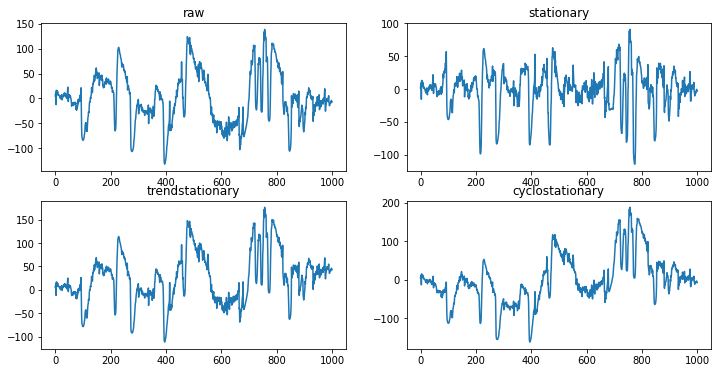

In [12]:
sequence_length = 1000
t = np.linspace(0,sequence_length,sequence_length)
plt.figure(figsize =(12, 6))
label = ['S1_raw','S2_raw','S1_stationary','S2_stationary',
         'S1_trendstationary','S2_trendstationary','S1_cyclostationary','S2_cyclostationary']


label = ['raw','stationary','trendstationary','cyclostationary']


for i in range(4):
  k = x[i*2]
  print(y[i*2])
  plt.subplot(2, 2, i+1)
  plt.plot(t,k)
  plt.title(label[i])
plt.show()  

In [13]:
!pip install mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.5 MB 5.1 MB/s 


In [14]:
import glob
import pickle
import mne

class load_dataset():
    def __init__(self, sbj_idx):
        self.sbj_idx = sbj_idx
        self.sequence_length = 2000

    def preprocessing_sleep_edf(self,data):
        data = mne.filter.resample(data, up = 2.0) # upsampling to 200Hz  
        return data
    
    def preprocessing_MASS(self,data):
        data = mne.filter.resample(data, down = 1.28) # downsampling to 200Hz  
        return data

    def split_data(self, data):
        L = self.sequence_length
        channels, length = data.shape
        a = 2000*int(length/2000)
        if length == a:
          data = np.reshape(data,(int(length/L*channels),1,L))
        else:
          data = data[:,:a]
          data = np.reshape(data,(int(length/L*channels)-1,1,L))
        data = np.squeeze(data,1)
        print(data.shape)
        return data

    #수정 필요, 
    #폴더에 MASS sample 1개, Sleep edf data 2개 넣어놓고 가져오는 방법,
    #MASS data와 Sleep data 합했을 때 어떻게 결과 나오는지 보기 위한 임시 방편.
    def load_data(self):
        X = []
        data_list = glob.glob('/content/drive/MyDrive/EEG_data/Sleep'+'/**')
        for sbj_idx in range(self.sbj_idx):
          a = data_list[sbj_idx]
          print(sbj_idx)
          with open(file = a , mode='rb') as f:
            sample = pickle.load(f)
          if sbj_idx <= 2:
            sample = self.preprocessing_sleep_edf(sample)
          else:
            sample = self.preprocessing_MASS(sample)
          sample = self.split_data(sample)
          X.extend(sample)
        return np.array(X)


    def call(self, fold):
        X = self.load_data()
        num_samples = int(X.shape[0]/(5)) # Samples per fold

        # Set training/validation/testing data indices
        rand_idx = np.random.RandomState(seed=981220).permutation(X.shape[0])
        test_idx = rand_idx[(fold - 1) * num_samples:fold * num_samples]
        train_idx = np.setdiff1d(rand_idx, test_idx)
        valid_idx = np.random.RandomState(seed=3940).permutation(train_idx.shape[0])[:num_samples]
        valid_idx = train_idx[valid_idx]
        train_idx = np.setdiff1d(train_idx, valid_idx)


        X_tr, X_vl, X_ts = X[train_idx, ...], X[valid_idx, ...], X[test_idx, ...]
        # Y_tr, Y_vl, Y_ts = Y[train_idx, ...], Y[valid_idx, ...], Y[test_idx, ...]
        del X
        return X_tr, X_vl ,X_ts

In [15]:
import glob
data_list = glob.glob('/content/drive/MyDrive/EEG_data/Sleep'+'/**')
print(data_list)

['/content/drive/MyDrive/EEG_data/Sleep/150.pickle', '/content/drive/MyDrive/EEG_data/Sleep/151.pickle', '/content/drive/MyDrive/EEG_data/Sleep/SS1_1.pickle', '/content/drive/MyDrive/EEG_data/Sleep/SS1_2.pickle', '/content/drive/MyDrive/EEG_data/Sleep/SS1_3.pickle']


EEGLoader

In [16]:
from torch.utils.data import Dataset
import torch

class EEGLoader(Dataset):
    def __init__(self, data, device):
        self.x_data = data

        # self.x_data = torch.Tensor(X_data).to(device)
        
    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, index):
        return self.x_data[index,:]

    def getallitem(self):
        return self.x_data

model

In [17]:
pip install separableconv-torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
import torch
import torch.nn as nn
import separableconv.nn as nns

def weight_init_xavier_uniform(submodule):
    if isinstance(submodule, nn.SeparableConv1d):
        torch.nn.init.xavier_uniform_(submodule.weight)

    if isinstance(submodule, nn.Linear):
        torch.nn.init.xavier_uniform_(submodule.weight)


class feature_extractor3(nn.Module):
    def __init__(self):
        super(feature_extractor3,self).__init__()
        
        self.channels = 1 # we use only single channel 
        
        # Regularizer
        #self.regularizer = tf.keras.regularizers.L1L2(l1=.001, l2=.01)

        # Activation functions
        self.activation = nn.LeakyReLU()
        self.bn = nn.BatchNorm1d(1)

        # self.conv2t = nns.SeparableConv1d(16,32,10,padding ='same') (in_channels, out_channels, kernel size,,,) 

        self.softmax = nn.Softmax()
        self.conv1t = nns.SeparableConv1d(1,8, 30, padding ='same') #in_channels, out_channels, kernel_size, 
        self.conv1s = nn.Conv1d(8,8,self.channels)
        self.conv2t = nns.SeparableConv1d(8,16,15,padding ='same') 
        self.conv2s = nn.Conv1d(16,16,self.channels)
        self.conv3t = nns.SeparableConv1d(16,32,5,padding ='same')
        self.conv3s = nn.Conv1d(32,32,self.channels)
          
          
        # Flatteninig
        self.flatten = nn.Flatten()

        # Dropout
        self.dropout = nn.Dropout(0.5)

        # Decision making
        self.Linear = nn.Linear(112000 ,4) # 

      
    def embedding(self, x, random_mask=False):
        # print(x.shape)
        x = self.bn(x)
        x = self.activation(self.conv1t(x))
        f1 = self.activation(self.conv1s(x))

        x = self.activation(self.conv2t(x))
        f2 = self.activation(self.conv2s(x))

        x = self.activation(self.conv3t(x))
        f3 = self.activation(self.conv3s(x))
        
        # multi-scale feature representation by exploiting intermediate features
        feature = torch.cat([f1, f2, f3],dim = 1  )
        
        return feature

    def classifier(self, feature):
        # Flattening, dropout, mapping into the decision nodes
        feature = self.flatten(feature)
        feature = self.dropout(feature)
        y_hat = self.softmax(self.Linear(feature))
        return y_hat    

    def forward(self, x):
        feature = self.embedding(x)
        y_hat = self.classifier(feature)
        return y_hat

parameter setting

In [19]:
import os

# batch size
batch_size = 128
learning_rate = 0.0001
epochs = 20

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#"cpu"



In [20]:
print(device)

cuda:0


In [21]:
from torch.utils.data import DataLoader
#dataset 몇개를 사용할 것인지 결정 
idx = 3
tr, va, te = load_dataset(idx).call(5)

0
(16212, 2000)
1
(16728, 2000)
2
(166338, 2000)


In [22]:
# dataset loader
trainEEG = EEGLoader(tr, device)
valEEG = EEGLoader(va,device)
testEEG = EEGLoader(te,device)
print("tainLoader")
trainLoader = DataLoader(trainEEG, batch_size = batch_size, shuffle=True)
valLoader = DataLoader(valEEG, batch_size = batch_size, shuffle=True)
testLoader = DataLoader(testEEG, batch_size = batch_size, shuffle=True)

tainLoader


batch단위로 loss를 계산하는 방법입니다.

In [23]:
def augmented_data(x,window,a,b,c,d):
      x = np.squeeze(x)
      # b,c,t = x.shape
      # x = np.reshape(x,(b*c,t))
      # print(x.shape)
      x = x.numpy()
      samples, sequence_length = x.shape
      X = []
      Y = []
      x_maf = MAF(x,window)
      x_asln = asln(x,a,b)
      x_apn = apn(x,c,d)
      X.append(x)
      X.append(x_maf)
      X.append(x_asln)
      X.append(x_apn)

      #one-hot encoding
      original = [1,0,0,0]
      s_maf = [0,1,0,0]
      s_asln = [0,0,1,0]
      s_apn = [0,0,0,1]

      Y.append(original*np.ones((samples,1)))
      Y.append(s_maf*np.ones((samples,1)))
      Y.append(s_asln*np.ones((samples,1)))
      Y.append(s_apn*np.ones((samples,1)))
      
      X = np.array(X)

      X = X.reshape(4*samples,sequence_length)
      # print(X.shape)
      Y = np.array(Y)
      Y = Y.reshape(4*samples,4)
      
      return X,Y 

In [24]:
class Temporal_Trend_Identification_Task_Loss(torch.nn.modules.loss._Loss):
    def __init__(self, device = None):
        super().__init__()
        self.device = device

    def forward(self, batch, encoder, train):
        acc = 0
        x, y = augmented_data(batch,window =50 , a= 50, b = 0, c = 50, d= 1.5)
        c,t = x.shape
        x = np.reshape(x,(c,1,t))
        CrossEL = torch.nn.CrossEntropyLoss()
        pred = encoder.forward(torch.Tensor(x).to(device))
        y = torch.Tensor(y).to(device)
        _, y =  torch.max(y, 1) 
        
      
        # print('y:',y.shape)
        # print('rept:',rept.shape)
        loss = CrossEL(pred, torch.Tensor(y).to(device))
        if train:
            loss.backward(retain_graph=True)

        _, predicted = torch.max(pred, 1) 
        # print(predicted.shape)
        # print(y.shape)
        acc = (predicted == y).sum().item()
        acc = acc/c #acc/(batch*channels*4(augmented))
        loss = loss/c
        del x
        del y
        return loss, acc    
        

gpu memory 정리

In [25]:
import gc
gc.collect()

44

In [26]:
torch.cuda.empty_cache() # GPU 캐시 데이터 삭제

model, loss, optimizer settiong

In [27]:
model = feature_extractor3().to(device)
#model.to(device)
criterion = Temporal_Trend_Identification_Task_Loss(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [28]:
print(model)

feature_extractor3(
  (activation): LeakyReLU(negative_slope=0.01)
  (bn): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (softmax): Softmax(dim=None)
  (conv1t): SeparableConv1d(
    (dwconv): Conv1d(1, 1, kernel_size=(30,), stride=(1,), padding=same)
    (dwconv_normalization): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dwconv_activation): ReLU()
    (pwconv): Conv1d(1, 8, kernel_size=(1,), stride=(1,))
    (pwconv_normalization): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pwconv_activation): ReLU()
  )
  (conv1s): Conv1d(8, 8, kernel_size=(1,), stride=(1,))
  (conv2t): SeparableConv1d(
    (dwconv): Conv1d(8, 8, kernel_size=(15,), stride=(1,), padding=same, groups=8)
    (dwconv_normalization): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dwconv_activation): ReLU()
    (pwconv): Conv1d(8, 16, kernel_size=(1,), stride=(1,))
    (pw

learing

In [29]:
import matplotlib.pyplot as plt
loss_tr = []
loss_val = []
acc_tr = []
acc_val = []
for epoch in range(epochs):
    loss_ep = 0  # add batch loss in epoch
    acc_ep = 0
    for batch_idx, batch in enumerate(trainLoader):
        optimizer.zero_grad()
        loss_batch, acc_batch = criterion.forward(batch, model, train = True)
        # print(batch_idx)
        optimizer.step()
        loss_ep += loss_batch.item()
        acc_ep += acc_batch

    loss_tr.append((loss_ep)/len(trainLoader))
    acc_tr.append((acc_ep)/len(trainLoader))

    loss_ep_val = 0
    acc_ep_val = 0
    for batch_idx, batch in enumerate(valLoader):
        loss_batch_val, acc_batch_val = criterion.forward(batch, model, train = False)
        loss_ep_val += loss_batch_val.item()
        acc_ep_val += acc_batch_val
    
    loss_val.append((loss_ep_val)/len(valLoader))
    acc_val.append((acc_ep_val)/len(valLoader))
    print("epoch : ", epoch, "  train loss : ", loss_tr[epoch], 'train acc : ', acc_tr[epoch], "    val loss : ", loss_val[epoch], 'val acc : ', acc_val[epoch])


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:304: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:882.)
  self.padding, self.dilation, self.groups)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


epoch :  0   train loss :  0.0016391188994468375 train acc :  0.916644385026738     val loss :  0.0015599288349338353 val acc :  0.9527889570120703
epoch :  1   train loss :  0.0015534793857216117 train acc :  0.9559805314171123     val loss :  0.001544513630319554 val acc :  0.9590562985883796
epoch :  2   train loss :  0.00153861532727366 train acc :  0.963598763368984     val loss :  0.001530943237668954 val acc :  0.9644653520100246
epoch :  3   train loss :  0.0015282807770847556 train acc :  0.9675405247326203     val loss :  0.0015233948547691584 val acc :  0.9685715229473539
epoch :  4   train loss :  0.0015242532868047847 train acc :  0.969610628342246     val loss :  0.0015173148097416672 val acc :  0.971135732064921
epoch :  5   train loss :  0.0015208614734873015 train acc :  0.971524064171123     val loss :  0.001515806586935352 val acc :  0.9720203922019913
epoch :  6   train loss :  0.00151245309585297 train acc :  0.9750772894385027     val loss :  0.0015091950526066984

result save and plot

In [35]:
import pandas as pd
col = ['loss_tr','loss_val','acc_tr','acc_val']
data = np.array([loss_tr,
                 loss_val,
                 acc_tr,
                 acc_val])
print(data.shape)
data = np.transpose(data)
df = pd.DataFrame(data = data, columns= col)
df.to_excel('Sleepedf+MASS_10s.xlsx', index = False)

(4, 20)


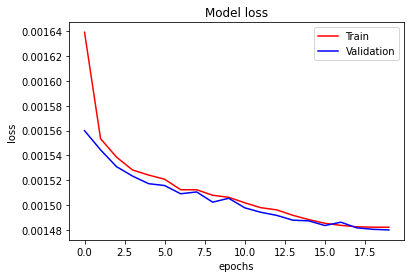

In [34]:
# plt.figure(figsize =(15, 10))
plt.plot(range(epochs), loss_tr, color='red')
plt.plot(range(epochs), loss_val, color='blue')
plt.title('Model loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig('Sleepedf+MASS_loss_10s')
plt.show()


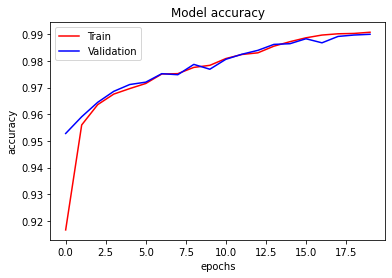

In [36]:
# plt.figure(figsize =(15, 10))
plt.plot(range(epochs), acc_tr, color='red')
plt.plot(range(epochs), acc_val, color='blue')
plt.title('Model accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('Sleepedf+MASS_accuracy_10s')
plt.show()

In [37]:
torch.cuda.empty_cache() # GPU 캐시 데이터 삭제

In [49]:
def predict( batch, encoder):
  x, y = augmented_data(batch,window = 50 , a= 50, b = 0, c = 50, d= 1.5)
  c,t = x.shape
  # print('bj',x.shape)
  x = np.reshape(x,(c,1,t))
      
  rept = encoder.forward(torch.Tensor(x).to(device))
  
  rept = rept.cpu().detach().numpy()
  
  return rept, y

In [50]:
Y_hat = []
Y = []
for batch_idx, batch in enumerate(testLoader):
  y_hat,y = predict(batch, encoder = model)

  Y_hat.extend(y_hat)
  Y.extend(y)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [51]:
Y_hat = np.array(Y_hat)
print(Y_hat.shape)

Y = np.array(Y)
print(Y.shape)

(159420, 4)
(159420, 4)


In [52]:
y_hat

array([[1.00000000e+00, 1.38781320e-13, 6.33183269e-28, 5.78944173e-13],
       [1.00000000e+00, 5.68015359e-08, 1.88868631e-26, 1.06687081e-11],
       [1.00000000e+00, 9.15200233e-25, 1.53716727e-26, 1.16785495e-26],
       [1.00000000e+00, 1.64166701e-30, 4.38250414e-28, 1.03026802e-31],
       [9.99976873e-01, 2.30784972e-05, 2.59524237e-26, 1.65938208e-10],
       [1.00000000e+00, 9.91037510e-40, 1.42484559e-18, 1.70315751e-19],
       [1.00000000e+00, 6.14276855e-18, 5.24781195e-28, 2.17716665e-12],
       [1.00000000e+00, 7.45433554e-13, 1.25349516e-32, 2.84420163e-26],
       [1.00000000e+00, 2.46159115e-27, 5.74943051e-28, 2.59093688e-21],
       [1.00000000e+00, 4.12866876e-12, 3.28446046e-28, 4.30050665e-22],
       [1.00000000e+00, 1.59603380e-15, 9.87008092e-24, 1.21336875e-24],
       [1.00000000e+00, 3.34662770e-10, 2.11773358e-24, 3.92831180e-15],
       [1.00000000e+00, 3.29199481e-38, 1.59426787e-24, 1.50144070e-23],
       [1.00000000e+00, 2.02070958e-31, 9.74751270e

In [53]:
Y_tensor = torch.Tensor(Y)
_, Y_tensor =  torch.max(Y_tensor, 1) 
Y_hat_tensor = torch.Tensor(Y_hat)


_, predicted = torch.max(Y_hat_tensor, 1) 
# print(predicted.shape)
# print(y.shape)
print(predicted.shape)
correct = (predicted == Y_tensor).sum().item()
wrong = len(Y) - correct

torch.Size([159420])


In [54]:
print(Y_tensor)
print(predicted)

tensor([0, 0, 0,  ..., 3, 3, 3])
tensor([0, 0, 0,  ..., 3, 3, 3])


In [55]:
correct, wrong

(157838, 1582)

In [59]:
print('accuracy:',correct/(correct + wrong))

accuracy: 0.990076527411868


In [56]:
# confusion matrix 사용을 위한 라이브러리
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(Y_tensor, predicted)
print(conf_matrix)



[[39381   164   137   173]
 [  533 39322     0     0]
 [  209     0 39527   119]
 [  173     0    74 39608]]


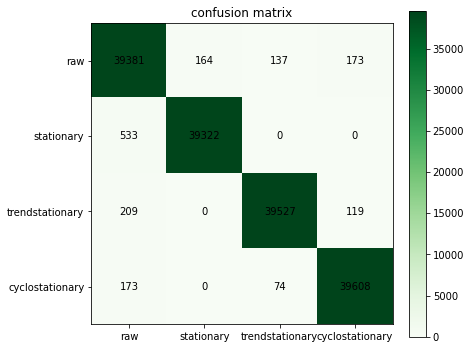

In [62]:
#one-hot encoding
      # original = [1,0,0,0]
      # s_maf = [0,1,0,0]
      # s_asln = [0,0,1,0]
      # s_apn = [0,0,0,1]

title = 'confusion matrix'
cmap=plt.cm.Greens
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=cmap)  # , cmap=plt.cm.Greens
plt.title(title, size=12)
plt.colorbar(fraction=0.05, pad=0.05)
tick_marks = np.arange(4, 4)
plt.xticks(np.arange(4), ('raw','stationary','trendstationary','cyclostationary'))
plt.yticks(np.arange(4), ('raw','stationary','trendstationary','cyclostationary'))


fmt = 'd' 
thresh = 1
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], fmt),
                 ha="center", va="center", color="black" if conf_matrix[i, j] > thresh else "black")  #horizontalalignment
plt.savefig('Sleepedf+MASS_confusionmatrix_10s',bbox_inches = 'tight')